### Google automl의 Efficientdet 다운로드 및 설치

In [ ]:
!git clone --depth 1 https://github.com/google/automl

In [ ]:
!cd ./automl/efficientdet; pip install -r requirements.txt

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
!nvidia-smi

Mon Mar 11 10:26:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P8              18W / 170W |   1062MiB / 12288MiB |     33%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### efficientdet 수행을 위한 Library path 설정. 
* efficientdet을 setup을 하지 않고, 소스코드를 sys.path.append('/content/automl/efficientdet')로 library path 설정. 

In [3]:
import os
import sys
import tensorflow.compat.v1 as tf

In [4]:
sys.path.append('C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet')

In [5]:
sys.path.append('C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV')

In [6]:
# /content/automl/efficient 으로 library path가 정상적으로 잡히면 아래 모듈 import가 되어야함. 
import hparams_config

from tf2 import anchors
from model_inspect import ModelInspector

### COCO 데이터로 Pretrained된 efficientdet-d0 모델을 다운로드

In [7]:
MODEL = 'efficientdet-d0' 

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

--2024-03-11 10:32:45--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.91, 34.64.4.59, 34.64.4.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28994253 (28M) [application/octet-stream]
Saving to: 'efficientdet-d0.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  440K 64s
    50K .......... .......... .......... .......... ..........  0%  389K 68s
   100K .......... .......... .......... .......... ..........  0%  156M 46s
   150K .......... .......... .......... .......... ..........  0% 4.17M 36s
   200K .......... .......... .......... .......... ..........  0% 8.54M 29s
   250K .......... .......... .......... .......... ..........  1% 11.5M 25s
   300K .......... .......... .......... .......... ..........  1% 10.4M 21s
   350K .......

Use model in c:\Users\LegendKi\Documents\LegendKi_py\Deeplearning_CV\efficientdet\efficientdet-d0


In [8]:
!wget -O ../data/img01.png https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png

--2024-03-11 10:34:25--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4080549 (3.9M) [image/png]
Saving to: '../data/img01.png'

     0K .......... .......... .......... .......... ..........  1%  288K 14s
    50K .......... .......... .......... .......... ..........  2%  831K 9s
   100K .......... .......... .......... .......... ..........  3%  570K 8s
   150K .......... .......... .......... .......... ..........  5% 1.69M 7s
   200K .......... .......... .......... .......... ..........  6%  510K 7s
   250K .......... .......... .......... .......... ..........  7% 2.60M 6s
   300K .......... .......... .......... .....

(1080, 1920, 3)


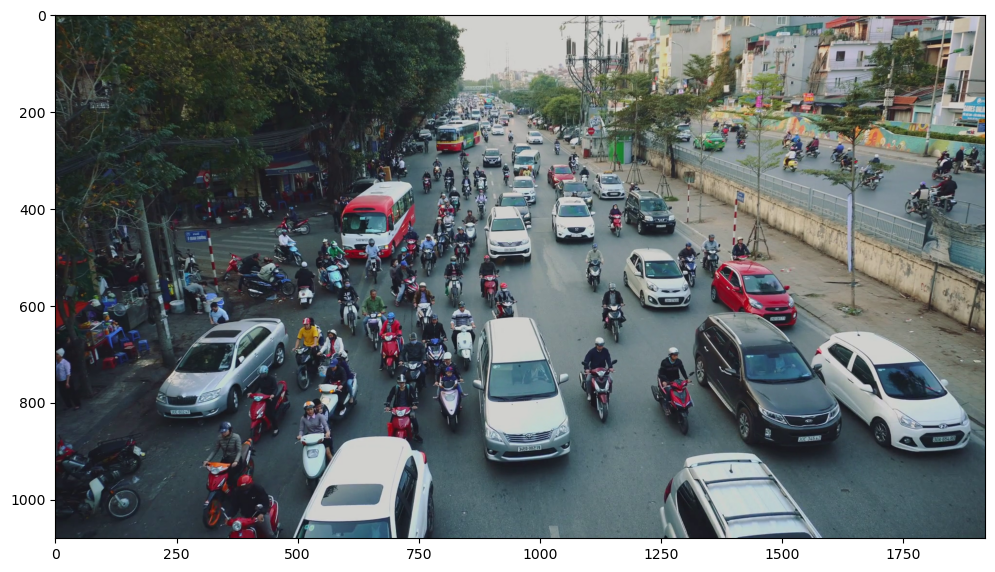

In [9]:
import cv2
import matplotlib.pyplot as plt

image_array = cv2.cvtColor(cv2.imread('../data/img01.png'), cv2.COLOR_BGR2RGB)
print(image_array.shape)

plt.figure(figsize=(12, 12))
plt.imshow(image_array)

### Pretrained efficientdet 모델로 Inference 를 수행하기 위한 환경 설정
* hparams_config.Config 객체를 통해 모델 환경 설정. 

In [10]:
class INFER_CFG:
  model_name = 'efficientdet-d0' # efficientdet 모델명
  model_dir = '../efficientdet/efficientdet-d0' # pretrained checkpoint 파일이 있는 디렉토리
  hparams = '' # csv 형식의 k=v 쌍 또는 yaml file

In [11]:
import numpy as np
from PIL import Image
import tensorflow as tf

import hparams_config
import inference
from tf2 import efficientdet_keras

In [12]:
#efficientdet-d0의 기본 config 확인. 
config = hparams_config.get_efficientdet_config(INFER_CFG.model_name)
print('config type:', type(config))
print(config)

config type: <class 'hparams_config.Config'>
act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_l

In [13]:
# config의 특정 항목을 update
config.is_training_bn = False
#config.image_size = '1920x1280'
config.nms_configs.score_thresh = 0.4
config.nms_configs.max_output_size = 100

config.override(INFER_CFG.hparams)

In [14]:
# P100 GPU Card에서는 아래 수행하지 말것. V100 GPU 시에는 mixed_float16으로 mixed_precision 설정. 

#policy = tf.keras.mixed_precision.Policy('mixed_float16')
#tf.keras.mixed_precision.set_global_policy(policy)
#tf.keras.mixed_precision.set_global_policy('mixed_float16')
#tf.config.run_functions_eagerly(MODEL_CONFIG.debug)

### Pretrained 모델 생성 후 Inference 수행
* config인자로 하여 EfficientDetModel생성  
* 만들어진 모델에 다운로드 된 Pretrained Weight 파일의 weight값을 model.load_weights()로 입력  

In [15]:
INFER_CFG.model_dir

'../efficientdet/efficientdet-d0'

In [16]:
import inference
from tf2 import efficientdet_keras

model = efficientdet_keras.EfficientDetModel(config=config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(INFER_CFG.model_dir))
model.load_weights(tf.train.latest_checkpoint(INFER_CFG.model_dir))
model.summary()

C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_file49j5og4z.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


#### checkpoint name: ../efficientdet/efficientdet-d0\model
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Model)     multiple                  3634844   
                                                                 
 resample_p6 (ResampleFeatur  multiple                 20800     
 eMap)                                                           
                                                                 
 resample_p7 (ResampleFeatur  multiple                 0         
 eMap)                                                           
                                                                 
 fpn_cells (FPNCells)        multiple                  179321    
                                                                 
 class_net (ClassNet)        multiple                  71274     
                                                                 
 box_net (BoxNet)            multiple                  20964     


In [17]:
from PIL import Image
import cv2

# image는 4차원 array, Tensor 모두 가능.  
imgs = [np.array(Image.open('../data/img01.png'))]
imgs = tf.convert_to_tensor(imgs, dtype=tf.uint8)

### 아래와 같이 numpy array도 모델에 입력되는 이미지 값으로 가능. 
''' 
img = cv2.cvtColor(cv2.imread('../data/img01.png'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]
boxes, scores, classes, valid_len = model(imgs, training=False, post_mode='global')
'''
print()

In [18]:
import time

# Inference 수행하고 수행 시간을 측정. 
start_time = time.time()
boxes, scores, classes, valid_len = model(imgs, training=False, post_mode='global')
print('elapsed time:', time.time() - start_time)

C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


elapsed time: 5.083230972290039


### Inference 반환 결과 살펴보고 API로 시각화 하기
* inference model에 image tensor를 입력하여 반환된 결과는 모두 tensor이며, bounding box의 좌표, confidence score, class id 값, valid한 갯수가 반환됨. 
* config에 max_instances_per_image이 100으로 설정되었으므로 기본적으로 inference결과는 100개의 object들의 Detection 결과를 가지게 됨. 
* 이들 중 valid한 갯수(valid_len)은 이들중 의미있는 object detection 갯수를 의미함.(0 부터 valid_len-1 까지의 index를 가진 array결과가 의미있는 detection 결과임)
* inference.visualize_image()로 반화 결과를 입력하여 시각화 적용

In [19]:
boxes

<tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[ 898.77655  , 1250.5496   , 1078.9359   , 1593.3431   ],
        [ 485.65433  , 1178.6992   ,  613.155    , 1317.921    ],
        [ 620.4387   , 1313.1923   ,  905.7957   , 1625.1449   ],
        [ 870.5326   ,  490.03906  , 1078.4777   ,  778.79535  ],
        [ 505.97095  , 1356.5165   ,  636.87384  , 1533.2822   ],
        [ 628.0898   ,  211.97456  ,  842.74146  ,  485.73227  ],
        [ 648.42664  , 1553.6306   ,  911.20715  , 1901.6498   ],
        [ 875.3992   ,    3.3170054, 1039.739    ,  182.61443  ],
        [ 925.4865   ,  301.9041   , 1075.1123   ,  460.30618  ],
        [ 619.0684   ,  873.7226   ,  928.01685  , 1069.778    ],
        [ 351.75238  ,  582.6803   ,  511.39185  ,  738.40454  ],
        [ 690.20953  , 1238.693    ,  860.3719   , 1316.6669   ],
        [ 677.6339   , 1087.3593   ,  835.46545  , 1159.2025   ],
        [ 677.30444  , 1864.0316   ,  759.29346  , 1864.0316   ],
        [ 677.30444  , 

In [20]:
print(valid_len.numpy())
boxes.shape, scores.shape, classes.shape

[13]


(TensorShape([1, 100, 4]), TensorShape([1, 100]), TensorShape([1, 100]))

In [21]:
scores

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.84585595, 0.6977483 , 0.68898976, 0.68414855, 0.6794167 ,
        0.64918184, 0.6143686 , 0.48414823, 0.44819963, 0.4399347 ,
        0.41509506, 0.41485375, 0.41327423, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        

In [22]:
print('##bboxes:', boxes[0, :10], '\n##scores:', scores[0, :10], '\n##classes:', classes[0, :10])

##bboxes: tf.Tensor(
[[ 898.77655   1250.5496    1078.9359    1593.3431   ]
 [ 485.65433   1178.6992     613.155     1317.921    ]
 [ 620.4387    1313.1923     905.7957    1625.1449   ]
 [ 870.5326     490.03906   1078.4777     778.79535  ]
 [ 505.97095   1356.5165     636.87384   1533.2822   ]
 [ 628.0898     211.97456    842.74146    485.73227  ]
 [ 648.42664   1553.6306     911.20715   1901.6498   ]
 [ 875.3992       3.3170054 1039.739      182.61443  ]
 [ 925.4865     301.9041    1075.1123     460.30618  ]
 [ 619.0684     873.7226     928.01685   1069.778    ]], shape=(10, 4), dtype=float32) 
##scores: tf.Tensor(
[0.84585595 0.6977483  0.68898976 0.68414855 0.6794167  0.64918184
 0.6143686  0.48414823 0.44819963 0.4399347 ], shape=(10,), dtype=float32) 
##classes: tf.Tensor([3. 3. 3. 3. 3. 3. 3. 4. 4. 3.], shape=(10,), dtype=float32)


In [24]:
for i, img in enumerate(imgs):
  length = valid_len[i]
  
  img = inference.visualize_image(
      img,
      boxes[i].numpy()[:length],
      classes[i].numpy().astype(int)[:length],
      scores[i].numpy()[:length],
      label_map=config.label_map,
      min_score_thresh=config.nms_configs.score_thresh,
      max_boxes_to_draw=config.nms_configs.max_output_size)
  
  output_image_path = os.path.join('../data/run_image/', str(i) + '.jpg')
  Image.fromarray(img).save(output_image_path)
  print('writing annotated image to %s' % output_image_path)

writing annotated image to ../data/run_image/0.jpg


### Static Graph mode(Non eager mode)로 Inference 수행 성능 향상 시키기
* @tf.function을 이용하여 static mode로 inference를 수행할 수 있도록 ExportModel 클래스 생성
* inference 수행 시 ExportModel의 @tf.function이 적용된 메소드를 호출할 수 있도록 함. 

In [25]:
import time

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [26]:
# p100에서 image 1920x1280일 경우 74ms, v100에서 image 512x512일 경우 24ms

start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_file49j5og4z.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


elapsed time: 3.07533860206604


### 시각화 함수 생성하고 inference 결과를 시각화

In [27]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [28]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

car: 0.8458
car: 0.6977
car: 0.6890
car: 0.6843
car: 0.6794
car: 0.6492
car: 0.6143
motorcycle: 0.4842
motorcycle: 0.4482
car: 0.4399
bus: 0.4153
person: 0.4149
motorcycle: 0.4131
Detection 수행시간: 0.14 초


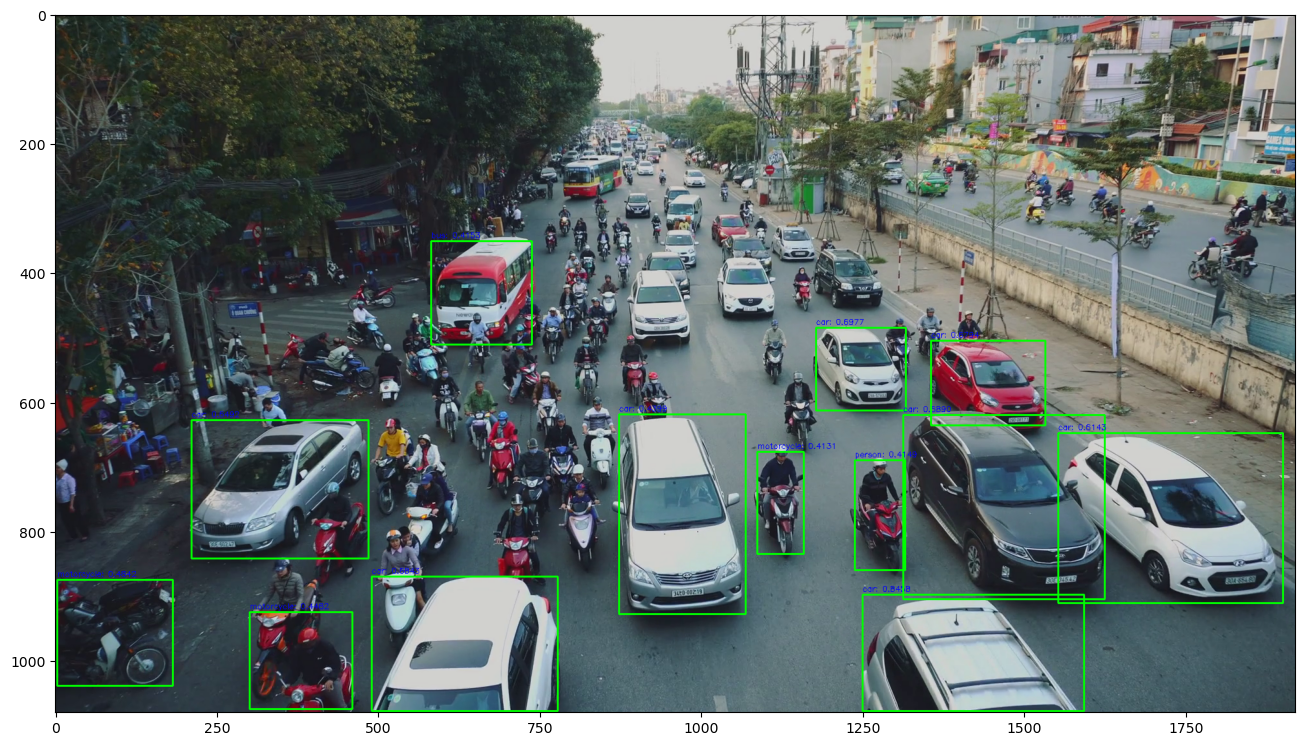

In [29]:
import cv2
img_array = cv2.cvtColor(cv2.imread('../data/img01.png'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)

(633, 806, 3)


C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_file49j5og4z.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


person: 0.9486
person: 0.9406
person: 0.9361
person: 0.8914
car: 0.6030
car: 0.5253
Detection 수행시간: 1.88 초


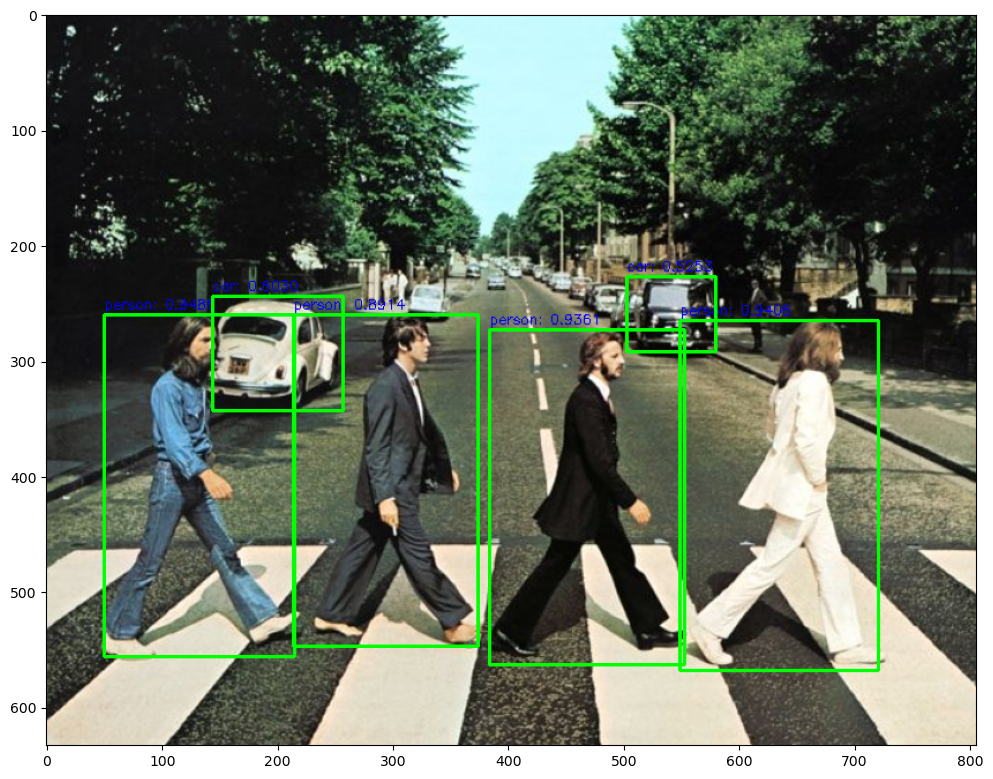

In [30]:
import cv2
img_array = cv2.cvtColor(cv2.imread('../data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
print(img_array.shape)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### pretrained된 last checkpoint 모델의 weight를 다시 load_weight() 적용시 런타임 재시작을 적용해야 함.
* 이를 위해 앞의 로직을 아래 셀에서 모두 일괄 정리함 

In [1]:
import os
import sys
import tensorflow.compat.v1 as tf
import numpy as np

sys.path.append('C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet')

import hparams_config
from tf2 import anchors
from model_inspect import ModelInspector

class INFER_CFG:
  model_name = 'efficientdet-d0' # efficientdet 모델명
  model_dir = '../efficientdet/efficientdet-d0' # pretrained checkpoint 파일이 있는 디렉토리
  hparams = '' # csv 형식의 k=v 쌍 또는 yaml file

config = hparams_config.get_efficientdet_config(INFER_CFG.model_name)
config.is_training_bn = False
# config의 image_size를 원본 이미지 사이즈로 재 조정. config의 image_size에 가로x세로 형식으로 문자열 입력 
config.image_size = '1920x1280'
config.nms_configs.score_thresh = 0.4
config.nms_configs.max_output_size = 100
config.override(INFER_CFG.hparams)

import inference
from tf2 import efficientdet_keras

model = efficientdet_keras.EfficientDetModel(config=config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(INFER_CFG.model_dir))
# pretrained된 last checkpoint 모델의 weight를 다시 load_weight() 적용시 런타임 재시작을 적용해야 함. 
model.load_weights(tf.train.latest_checkpoint(INFER_CFG.model_dir))
model.summary()

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_file7dxkhot9.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


#### checkpoint name: ../efficientdet/efficientdet-d0\model
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Model)     multiple                  3634844   
                                                                 
 resample_p6 (ResampleFeatur  multiple                 20800     
 eMap)                                                           
                                                                 
 resample_p7 (ResampleFeatur  multiple                 0         
 eMap)                                                           
                                                                 
 fpn_cells (FPNCells)        multiple                  179321    
                                                                 
 class_net (ClassNet)        multiple                  71274     
                                                                 
 box_net (BoxNet)            multiple                  20964     


In [2]:
# p100에서 image 1920x1280일 경우 74ms, image 512x512일 경우 27ms, v100에서 image 512x512일 경우 24ms
import time
import cv2 

img = cv2.cvtColor(cv2.imread('../data/img01.png'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]

start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_file7dxkhot9.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


elapsed time: 5.23175311088562


In [3]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [4]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

car: 0.9020
car: 0.8521
car: 0.8485
car: 0.8333
car: 0.8324
car: 0.8283
car: 0.8254
motorcycle: 0.8187
car: 0.8071
person: 0.7913
car: 0.7907
motorcycle: 0.7843
motorcycle: 0.7740
car: 0.7728
person: 0.7693
person: 0.7680
bus: 0.7671
person: 0.7565
person: 0.7546
person: 0.7470
person: 0.7444
car: 0.7235
person: 0.7189
motorcycle: 0.7106
person: 0.7092
person: 0.7054
person: 0.7017
person: 0.6909
car: 0.6864
motorcycle: 0.6839
person: 0.6829
person: 0.6798
motorcycle: 0.6749
person: 0.6731
bus: 0.6671
car: 0.6645
person: 0.6572
person: 0.6565
person: 0.6476
car: 0.6472
person: 0.6434
person: 0.6376
person: 0.6323
car: 0.6319
person: 0.6286
person: 0.6283
person: 0.6231
person: 0.6180
car: 0.6170
car: 0.6084
person: 0.6049
person: 0.6043
car: 0.6012
person: 0.5999
person: 0.5898
car: 0.5814
person: 0.5773
motorcycle: 0.5734
person: 0.5704
person: 0.5556
motorcycle: 0.5505
person: 0.5492
person: 0.5385
person: 0.5355
person: 0.5345
person: 0.5344
motorcycle: 0.5325
motorcycle: 0.5286
per

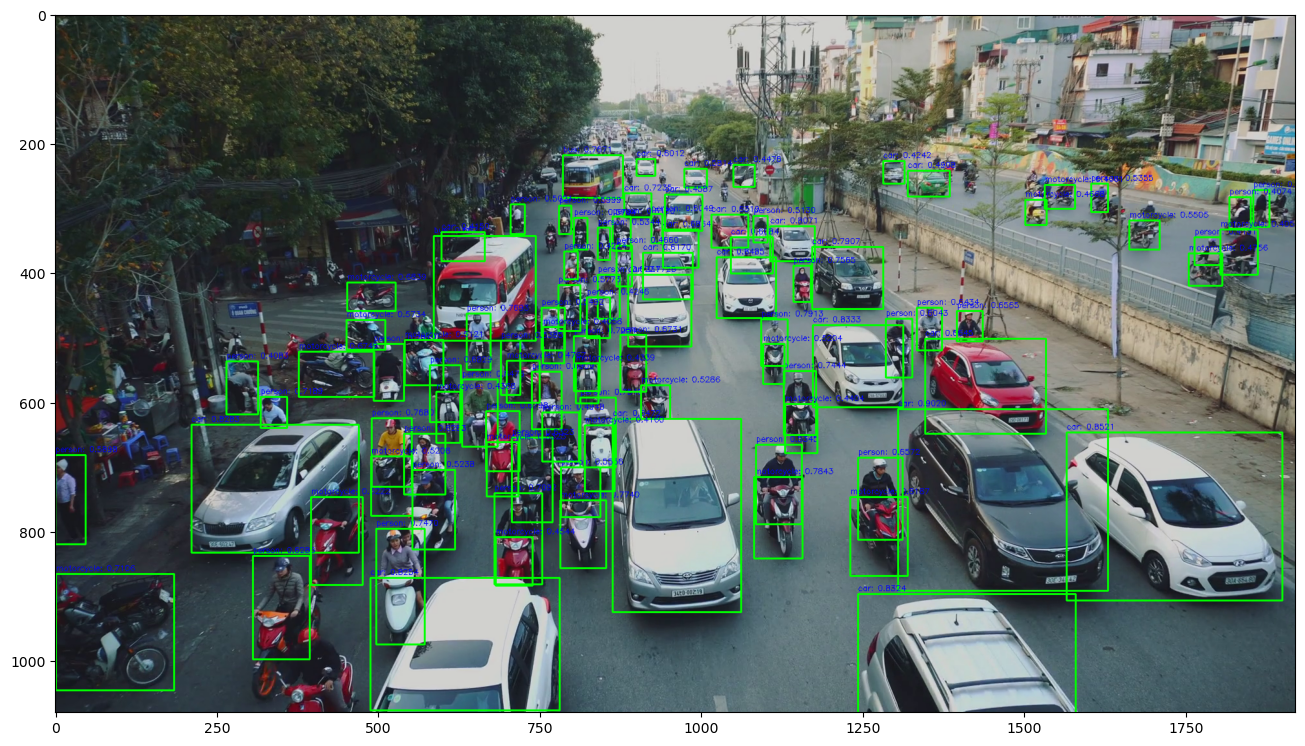

In [5]:
import cv2
import matplotlib.pyplot as plt

img_array = cv2.cvtColor(cv2.imread('../data/img01.png'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)